In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Questions 1 and 2 -- Get, Display, and Describe Data

1. Describe the data clearly -- particularly any missing data that might impact your analysis -- and the provenance of your dataset. Who collected the data and why? (10/100 pts)
2. What phenomenon are you modeling? Provide a brief background on the topic, including definitions and details that are relevant to your analysis. Clearly describe its main features, and support those claims with data where appropriate. (10/100 pts)

- What ARE we modeling? Who ends up with our hand-me downs?

Notes about data:
    - TIV stands for "Trend-Indicator Value", it's a way to measure the overall value of a transfer, which not only include the monetary price, but also things like how old the weapons are and if they're second hand. 

In [2]:
# Make sure we can see all the columns
pd.set_option('display.max_columns', None)

# Read in data -- need to skip 11 metadata rows at top, need so specify encoder, low_memory to avoid overloading
transfer_data = pd.read_csv('weapons_transfer_data.csv', skiprows=11, encoding='latin-1', low_memory=True)
# Drop unnecessary columns
transfer_data = transfer_data.drop([' .1', ' .2', ' '], axis=1)
# Change some column names
transfer_data = transfer_data.rename({'Year of order': 'Order Year', 'Year(s) of delivery': 'Delivery Year(s)', 'SIPRI TIV per unit': 'Unit TIV', 'SIPRI TIV for total order': 'Total Order TIV', 'SIPRI TIV of delivered weapons': 'TIV of Delivered Weapons'}, axis=1)

transfer_data.head()

,Recipient,Supplier,Order Year,Number ordered,Weapon designation,Weapon description,Number delivered,Delivery Year(s),status,Comments,Unit TIV,Total Order TIV,TIV of Delivered Weapons
0,Afghanistan,Russia,2002.0,3.0,Mi-17,transport helicopter,3.0,2002,Second hand,Second-hand; aid,2.90,8.70,8.70
1,Afghanistan,Turkiye,2007.0,24.0,M-114 155mm,towed gun,24.0,2007,Second hand,Second-hand; aid,0.20,4.80,4.80
2,Afghanistan,United States,2004.0,188.0,M-113,armoured personnel carrier,188.0,2005,Second hand,Second-hand; aid; M-113A2 version; incl 15 M-5...,0.10,18.80,18.80
3,Afghanistan,United States,2016.0,53.0,S-70 Black Hawk,transport helicopter,53.0,2017; 2018; 2019; 2020,Second hand but modernized,Second-hand UH-60A modernized to UH-60A+ befor...,4.29,227.37,227.37
4,Afghanistan,Soviet Union,1973.0,100.0,T-62,tank,100.0,1975; 1976,New,NaN,1.80,180.00,180.00


In [3]:
# Checking for missing values in each column
# Should probably drop rows without 'Supplier' or 'Recipient'
for column in transfer_data.columns:
    print(f'{column:<20}: {transfer_data[column].isna().sum()} NaN rows.')

# Drop the (4) rows missing recipient
print('\nBefore dropping missing rows:', len(transfer_data))
transfer_data = transfer_data.dropna(subset=['Recipient'])
print('After dropping missing rows:',len(transfer_data))

Recipient           : 4 NaN rows.
Supplier            : 0 NaN rows.
Order Year          : 0 NaN rows.
Number ordered      : 290 NaN rows.
Weapon designation  : 4 NaN rows.
Weapon description  : 4 NaN rows.
Number delivered    : 4 NaN rows.
Delivery Year(s)    : 1159 NaN rows.
status              : 4 NaN rows.
Comments            : 5296 NaN rows.
Unit TIV            : 8 NaN rows.
Total Order TIV     : 8 NaN rows.
TIV of Delivered Weapons: 8 NaN rows.

Before dropping missing rows: 29507
After dropping missing rows: 29503


## Question 3 -- Describe and "Show Off" the Model

3. Describe your non-parametric model (empirical cumulative distribution functions, kernel density function, local constant least squares regression, Markov transition models). How are you fitting your model to the phenomenon to get realistic properties of the data? What challenges did you have to overcome? (15/100 pts)

In [4]:
# Creating the model here

# Not every country is a supplier or recipient, so we need to create a list of all countries
Suppliers = list(transfer_data['Supplier'].unique())
Recipients = list(transfer_data['Recipient'].unique())
countries = list(np.unique(np.array(Suppliers + Recipients)))

# Initialize matrix
S = len(countries)
tr_counts = np.zeros((S,S))

for _, transfer in transfer_data.iterrows():
    sup = transfer[1] # Supplying country
    rec = transfer[0] # Recieving country
    # Determine transition indices:
    index_from = countries.index(sup)
    index_to = countries.index(rec)
    # Update transition counts
    tr_counts[index_from, index_to] += 1

print('Transition counts', tr_counts
)


/tmp/ipykernel_13679/4090535607.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sup = transfer[1] # Supplying country
/tmp/ipykernel_13679/4090535607.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rec = transfer[0] # Recieving country


Transition counts [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 3. 0. 0.]]


In [5]:
# Testing transfers for the U.S.
us_idx = countries.index('United States')
transfers_from_supplier = tr_counts[us_idx, :]

# Display transfers from U.S.
df = pd.DataFrame([transfers_from_supplier], columns=countries)
df

,ANC (South Africa)*,Afghanistan,African Union**,Albania,Algeria,Amal (Lebanon)*,Angola,Anti-Castro rebels (Cuba)*,Antigua and Barbuda,Argentina,Armas (Guatemala)*,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Biafra,Bolivia,Bosnia-Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo,Contras (Nicaragua)*,Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,DR Congo,Darfur rebels (Sudan)*,Denmark,Djibouti,Dominican Republic,ELF (Ethiopia)*,EPLF (Ethiopia)*,East Germany (GDR),Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Ethiopia,European Union**,FAN (Chad)*,FMLN (El Salvador)*,FNLA (Angola)*,FRELIMO (Portugal)*,Fiji,Finland,France,GUNT (Chad)*,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Grenada,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Haiti rebels*,Hamas (Palestine)*,Hezbollah (Lebanon)*,HoR (Libya)*,Honduras,Houthi rebels (Yemen)*,Hungary,Iceland,India,Indonesia,Indonesia rebels*,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Katanga,Kazakhstan,Kenya,Khmer Rouge (Cambodia)*,Kosovo,Kurdistan Regional Government (Iraq)*,Kuwait,Kyrgyzstan,LF (Lebanon)*,LRA (Uganda)*,LTTE (Sri Lanka)*,Laos,Latvia,Lebanon,Lebanon Palestinian rebels*,Lesotho,Liberia,Libya,Lithuania,Luxembourg,MNLF (Philippines)*,MPLA (Portugal)*,MTA (Myanmar)*,Madagascar,Malawi,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mexico,Moldova,Mongolia,Montenegro,Morocco,Mozambique,Mujahedin (Afghanistan)*,Myanmar,NATO**,NLA (Macedonia)*,NTC (Libya)*,Namibia,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,North Korea,North Macedonia,North Yemen,Northern Alliance (Afghanistan)*,Northern Cyprus,Norway,OSCE**,Oman,PAIGC (Portugal)*,PKK (Turkiye)*,PLO (Israel)*,PRC (Israel/Palestine)*,Pakistan,Palestine,Palestinian Islamic Jihad (Israel/Palestine)*,Panama,Papua New Guinea,Paraguay,Pathet Lao (Laos)*,Peru,Philippines,Poland,Portugal,Provisional IRA (UK)*,Qatar,RPF (Rwanda)*,RUF (Sierra Leone)*,Regional Security System**,Romania,Russia,Rwanda,SLA (Lebanon)*,SNA (Somalia)*,SPLA (Sudan)*,Saint Kitts and Nevis,Saint Vincent,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Korea,South Sudan,South Vietnam,South Yemen,Southern rebels (Yemen)*,Soviet Union,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Syria rebels*,Taiwan,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Tonga,Trinidad and Tobago,Tunisia,Turkiye,Turkmenistan,UAE,UIC (Somalia)*,UNITA (Angola)*,Uganda,Ukraine,Ukraine Rebels*,United Kingdom,United Nations**,United States,United Wa State (Myanmar)*,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Cong (South Vietnam)*,Viet Minh (France)*,Viet Nam,Western Sahara,Yemen,Yemen Arab Republic (North Yemen),Yugoslavia,ZAPU (Zimbabwe)*,Zambia,Zimbabwe,eSwatini,unknown rebel group*,unknown recipient(s),unknown supplier(s)
0,0.0,34.0,1.0,5.0,23.0,0.0,5.0,1.0,0.0,166.0,7.0,0.0,0.0,215.0,38.0,3.0,5.0,85.0,17.0,1.0,0.0,92.0,2.0,2.0,1.0,2.0,54.0,7.0,15.0,167.0,16.0,11.0,5.0,2.0,0.0,29.0,16.0,185.0,1.0,17.0,149.0,4.0,184.0,0.0,2.0,9.0,15.0,7.0,16.0,15.0,3.0,19.0,0.0,23.0,0.0,115.0,6.0,61.0,0.0,0.0,0.0,72.0,229.0,60.0,3.0,0.0,11.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,132.0,0.0,11.0,0.0,7.0,165.0,10.0,285.0,0.0,49.0,1.0,0.0,7.0,27.0,1.0,0.0,0.0,2.0,56.0,0.0,12.0,0.0,62.0,117.0,1.0,111.0,93.0,7.0,291.0,239.0,25.0,362.0,153.0,0.0,4.0,25.0,0.0,4.0,0.0,76.0,0.0,0.0,0.0,0.0,19.0,13.0,61.0,0.0,2.0,12.0,16.0,23.0,8.0,0.0,0.0,0.0,2.0,1.0,66.0,0.0,5.0,4.0,3.0,1.0,152.0,0.0,1.0,3.0,115.0,0.0,3.0,22.0,6.0,0.0,0.0,3.0,4.0,205.0,46.0,24.0,8.0,32.0,0.0,7.0,16.0,0.0,0.0,125.0,0.0,57.0,0.0,0.0,0.0,0.0,168.0,0.0,0.0,22.0,1.0,26.0,0.0,129.0,164.0,85.0,103.0,0.0,44.0,0.0,0.0,1.0,40.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,261.0,5.0,5.0,2.0,2.0,128.0,8.0,12.0,0.0,8.0,24.0,379.0,1.0,86.0,0.0,0.0,0.0,229.0,28.0,14.0,1.0,72.0,47.0

In [6]:
# Sum transititon counts by row (INTO each state):
sums = tr_counts.sum(axis=0, keepdims=True)
#print('State proportions: \n')
#print(sums)

# Normalize transition count matrix to get proportions
tr_pr = np.divide(tr_counts, sums,
                  out=np.zeros_like(tr_counts),
                  where=sums!=0)
#print('State proportions: \n')
tr_df = pd.DataFrame(np.round(tr_pr,2), index=countries, columns=countries)
pd.set_option('display.max_columns', 10)

# This is the transition proportion matrix
tr_df

,ANC (South Africa)*,Afghanistan,African Union**,Albania,Algeria,...,Zimbabwe,eSwatini,unknown rebel group*,unknown recipient(s),unknown supplier(s)
ANC (South Africa)*,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
Afghanistan,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
African Union**,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
Albania,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
Algeria,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
eSwatini,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
unknown rebel group*,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0
unknown recipient(s),0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0


Text(120.7222222222222, 0.5, 'Supplier Country')

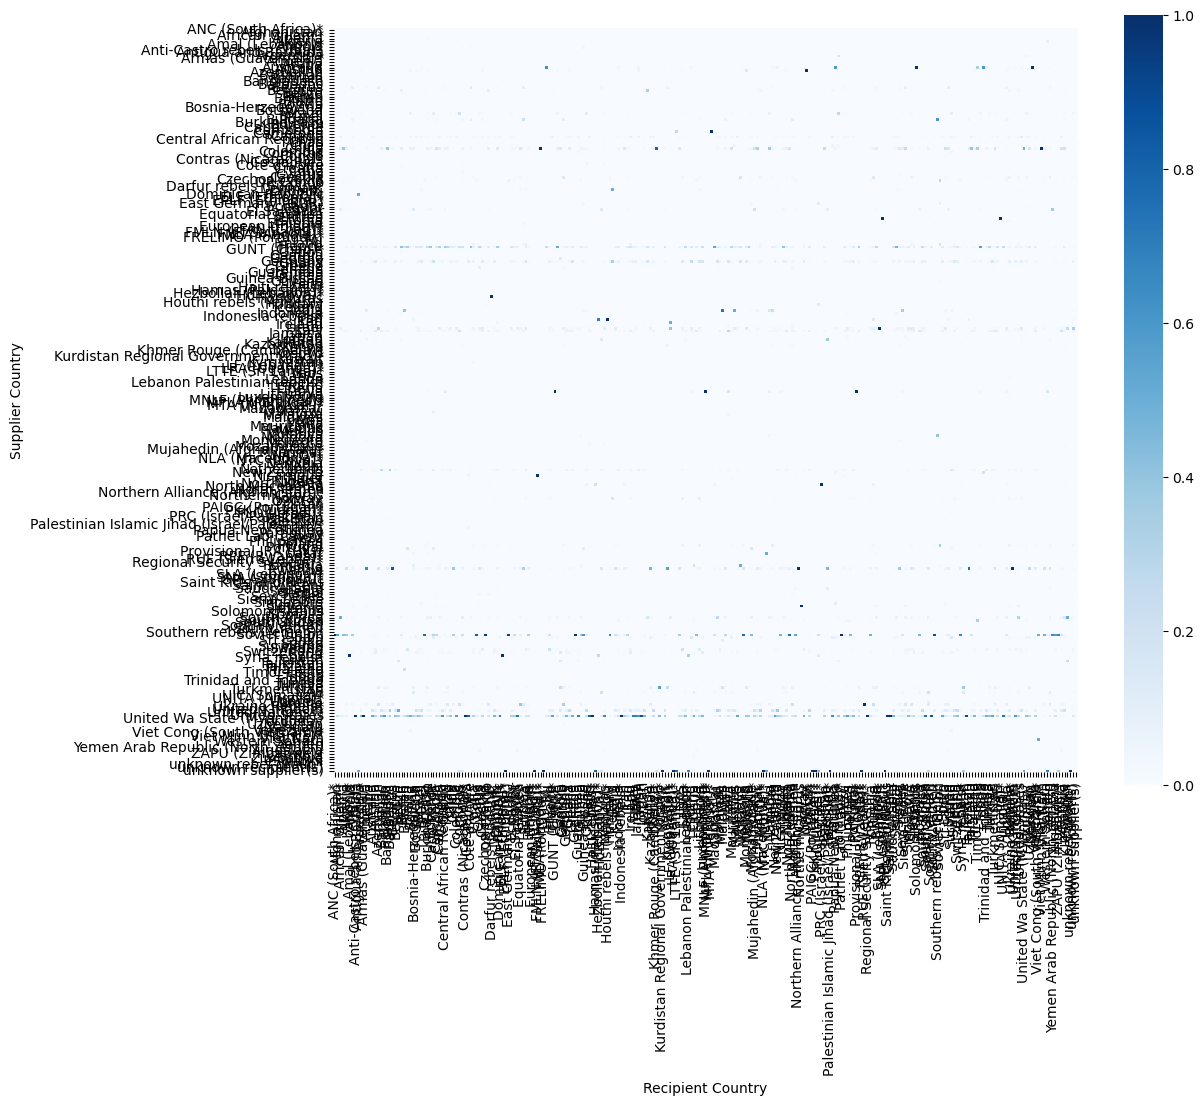

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(tr_pr,
            cmap='Blues',
            square=True,
            xticklabels=countries,
            yticklabels=countries,)
plt.xlabel('Recipient Country')
plt.ylabel('Supplier Country')

## Questions 4 and 5 -- Using and Evaluating the Model

4. Either use your model to create new sequences (if the model is more generative) or bootstrap a quantity of interest (if the model is more inferential). (15/100 pts)
5. Critically evaluate your work in part 4. Do your sequences have the properties of the training data, and if not, why not? Are your estimates credible and reliable, or is there substantial uncertainty in your results? (15/100 pts)

## Question 6 -- Conclusion

6. Write a conclusion that explains the limitations of your analysis and potential for future work on this topic. (10/100 pts)

In addition, submit a GitHub repo containing your code and a description of how to obtain the original data from the source. Make sure the code is commented, where appropriate. Include a .gitignore file. We will look at your commit history briefly to determine whether everyone in the group contributed. (10/100 pts)